In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
plt.rcParams['figure.dpi'] = 450

In [3]:
# data_dir = 'D:\\RST\\notebook\\networks\\'
# root_dir = 'D:\\RST\\notebook\\'

In [4]:
root_dir = '/Volumes/Data2/RST/notebook/'
data_dir = '/Volumes/Data2/RST/notebook/networks/'

In [5]:
period_order = pd.DataFrame.from_records([['EM', 1], ['AM', 2], ['MD', 3], ['PM', 4], ['EV', 5]], 
                          columns = ['period', 'period_order'])

In [6]:
tts = pd.read_csv(root_dir + 'TTS OD/TTS_TYPE.csv')
tts = tts.rename(columns = {'origin':'o_node', 'destination':'d_node'})

In [7]:
df_list = []
for period in ['EM', 'AM', 'MD', 'PM', 'EV']:
    
    for weight_type in ['raw', 'lico', 'c0', 'imm', 'rac', 'bl', 'ab', 'lep']:

        bc_avg = pd.read_csv(data_dir + period + '/' + 'BC-' + period + '_node-avg.csv' )

        bc_avg['o_node'] = bc_avg['o_node'] - 1000
        bc_avg['d_node'] = bc_avg['d_node'] - 1000

        period_tts = tts[tts['type'] == weight_type + '_' + period.lower()]

        stop_times_od = pd.read_csv(root_dir + 'networks/' + period + '-TE-16-8.csv')
        N = len((stop_times_od['INT_ID_o'].append(stop_times_od['INT_ID_d'])).drop_duplicates())

        bc_all = bc_avg.merge(period_tts)
        bc_od = bc_all.copy()
        bc_all['weighted'] = (bc_all['bc_single'] * bc_all['total'])

        bc_all = bc_all.groupby('INT_ID').agg({'weighted':'sum'}).reset_index()
        bc_all['weighted'] = bc_all['weighted']/((N - 1) * (N - 2) * period_tts['total'].sum())
        bc_all['type'] = weight_type + '_' + period.lower()
        
        df_list.append(bc_all)

In [8]:
bc_weighted = pd.concat(df_list)
bc_weighted

,INT_ID,weighted,type
0,100,4.222603e-09,raw_em
1,101,5.868707e-09,raw_em
2,102,9.315443e-09,raw_em
3,103,8.266396e-09,raw_em
4,104,1.257338e-08,raw_em
...,...,...,...
3688,30104484,1.536379e-09,lep_ev
3689,30109241,1.355866e-09,lep_ev
3690,30112870,2.356264e-10,lep_ev
3691,30113231,1.644184e-11,lep_ev


In [9]:
bc_weighted.to_csv('bc_weighted_node.csv', index = False)

# Entropy

Using log base e for entropy

In [10]:
table = []

for period in ['EM', 'AM', 'MD', 'PM', 'EV']:
    
    for weight_type in ['raw', 'lico', 'c0', 'imm', 'rac', 'bl', 'ab', 'lep']:
        
        temp = bc_weighted[bc_weighted['type'] == weight_type + '_' + period.lower()]
        entropy_bc = np.sum(np.log(temp['weighted']) * temp['weighted']) * -1
        mean_bc = np.mean(temp['weighted'])

        table.append([weight_type + '_' + period.lower(), weight_type, period, mean_bc, entropy_bc])
        
global_bc = pd.DataFrame.from_records(table, columns = ['type', 'group', 'period', 'mean_bc', 'entropy_bc'])

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [11]:
global_bc['mean_bc'] = global_bc['mean_bc'] * 1000000000
global_bc['entropy_bc'] = global_bc['entropy_bc'] * 100000

In [12]:
global_bc = global_bc.merge(period_order).sort_values(by = 'period_order')

In [13]:
global_bc[['group', 'period', 'mean_bc']].pivot('group', 'period', 'mean_bc')

period,AM,EM,EV,MD,PM
group,,,,,
ab,0.434701,1.371387,0.463420,0.362624,0.392508
bl,0.465473,1.410355,0.532278,0.409718,0.439521
c0,0.425735,1.614684,0.455306,0.366224,0.372357
imm,0.422599,1.475065,0.467714,0.366668,0.395467
lep,0.450386,1.422190,0.493516,0.388489,0.427840
lico,0.464196,1.580077,0.569711,0.420732,0.444844
rac,0.445481,1.463217,0.492935,0.387071,0.420071
raw,0.432645,1.383409,0.465611,0.369428,0.398992


In [14]:
global_bc[['group', 'period', 'entropy_bc']].pivot('group', 'period', 'entropy_bc')

period,AM,EM,EV,MD,PM
group,,,,,
ab,3.528260,5.815763,3.433728,2.850444,3.171741
bl,3.806241,6.058083,3.980544,3.251361,3.575594
c0,3.237095,5.603022,2.972563,2.659415,2.865318
imm,3.448003,6.306429,3.491703,2.913611,3.201443
lep,3.670061,6.102536,3.695945,3.089772,3.469215
lico,3.656268,5.555545,3.672402,3.029504,3.469666
rac,3.637730,6.283077,3.692329,3.078061,3.407421
raw,3.535587,5.960790,3.493190,2.938081,3.241513


In [15]:
cmap = mpl.cm.get_cmap('tab10')

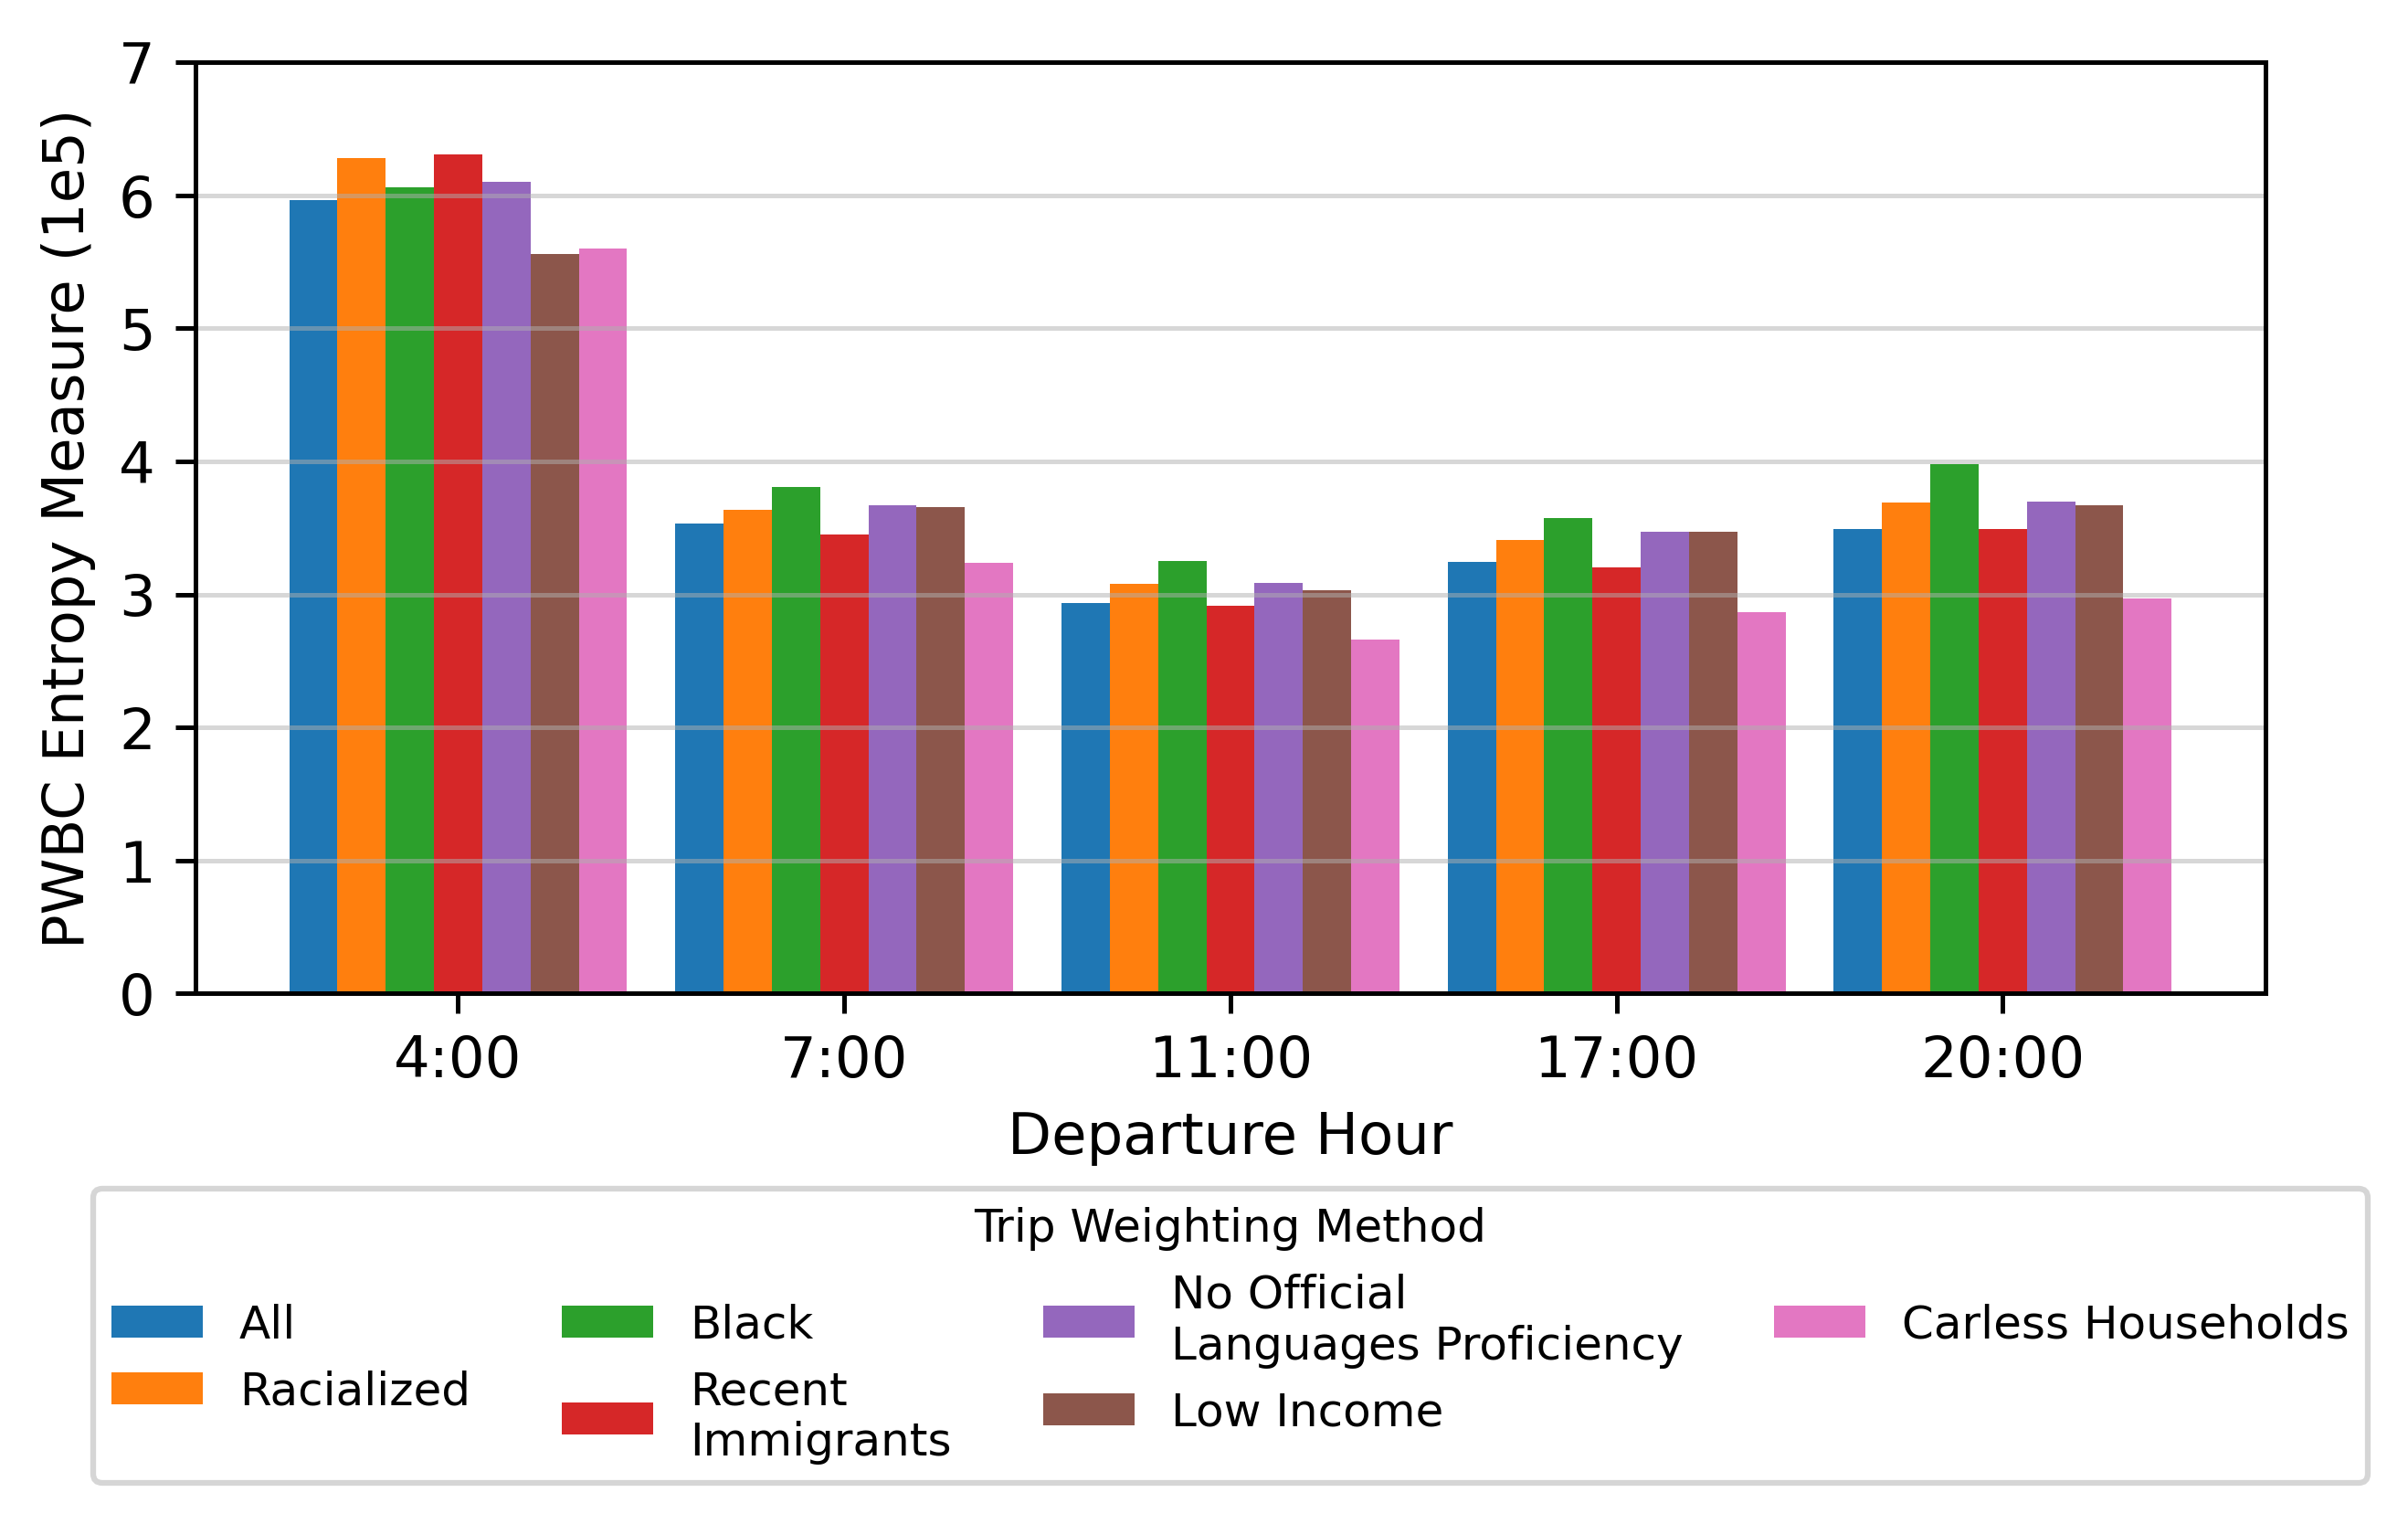

In [16]:
fig, ax = plt.subplots()

fig.set_size_inches(6.5,3)

x = np.arange(5) 

ax.grid(axis = 'y', alpha = 0.5)


plt.bar(x-3/8,global_bc[global_bc['group']=='raw']['entropy_bc'], width = 1/8, label = 'All', color = cmap(0))
plt.bar(x-2/8,global_bc[global_bc['group']=='rac']['entropy_bc'], width = 1/8, label = 'Racialized', color = cmap(1))
plt.bar(x-1/8,global_bc[global_bc['group']=='bl']['entropy_bc'], width = 1/8, label = 'Black', color = cmap(2))
plt.bar(x,global_bc[global_bc['group']=='imm']['entropy_bc'], width = 1/8, label = 'Recent\nImmigrants', color = cmap(3))
plt.bar(x+1/8,global_bc[global_bc['group']=='lep']['entropy_bc'], width = 1/8, label = 'No Official\nLanguages Proficiency', color = cmap(4))
plt.bar(x+2/8,global_bc[global_bc['group']=='lico']['entropy_bc'], width = 1/8, label = 'Low Income', color = cmap(5))
plt.bar(x+3/8,global_bc[global_bc['group']=='c0']['entropy_bc'], width = 1/8, label = 'Carless Households', color = cmap(6))

ax.set_ylim([0,7])

ax.set_xticks(range(5))
ax.set_xticklabels(['4:00', '7:00', '11:00', '17:00', '20:00'])

ax.set_xlabel('Departure Hour')
ax.set_ylabel('PWBC Entropy Measure (1e5)')

plt.legend(title = 'Trip Weighting Method', title_fontsize = 8, fontsize = 8, ncol = 4, 
           loc='lower center', bbox_to_anchor=(0.5, -0.55))

plt.savefig('bc_entropy.png', dpi = 300, bbox_inches = "tight")

In [17]:
df_list = []
i = 0
for period in ['EM', 'AM', 'MD', 'PM', 'EV']:
    
    for weight_type in ['raw', 'lico', 'c0', 'imm', 'rac', 'bl', 'ab', 'lep']:
        
        temp = bc_weighted[bc_weighted['type'] == weight_type + '_' + period.lower()].copy()
        temp_cutoff = temp['weighted'].quantile(0.95)
        temp = temp[temp['weighted'] >= temp_cutoff]
        temp['period'] = period
        temp['group'] = weight_type
        temp['order'] = i
        df_list.append(temp)
        i = i + 1

bc_95_mean = pd.concat(df_list)

In [18]:
bc_95_all = bc_95_mean

In [19]:
bc_95_all.groupby('type').count()

,INT_ID,weighted,period,group,order
type,,,,,
ab_am,202,202,202,202,202
ab_em,110,110,110,110,110
ab_ev,185,185,185,185,185
ab_md,194,194,194,194,194
ab_pm,202,202,202,202,202
bl_am,202,202,202,202,202
bl_em,110,110,110,110,110
bl_ev,185,185,185,185,185
bl_md,194,194,194,194,194


In [20]:
bc_95_mean = bc_95_mean.groupby(['order','period', 'group']).agg({'weighted':'mean'}).reset_index()
bc_95_mean['weighted'] = bc_95_mean['weighted'] * 1000000000

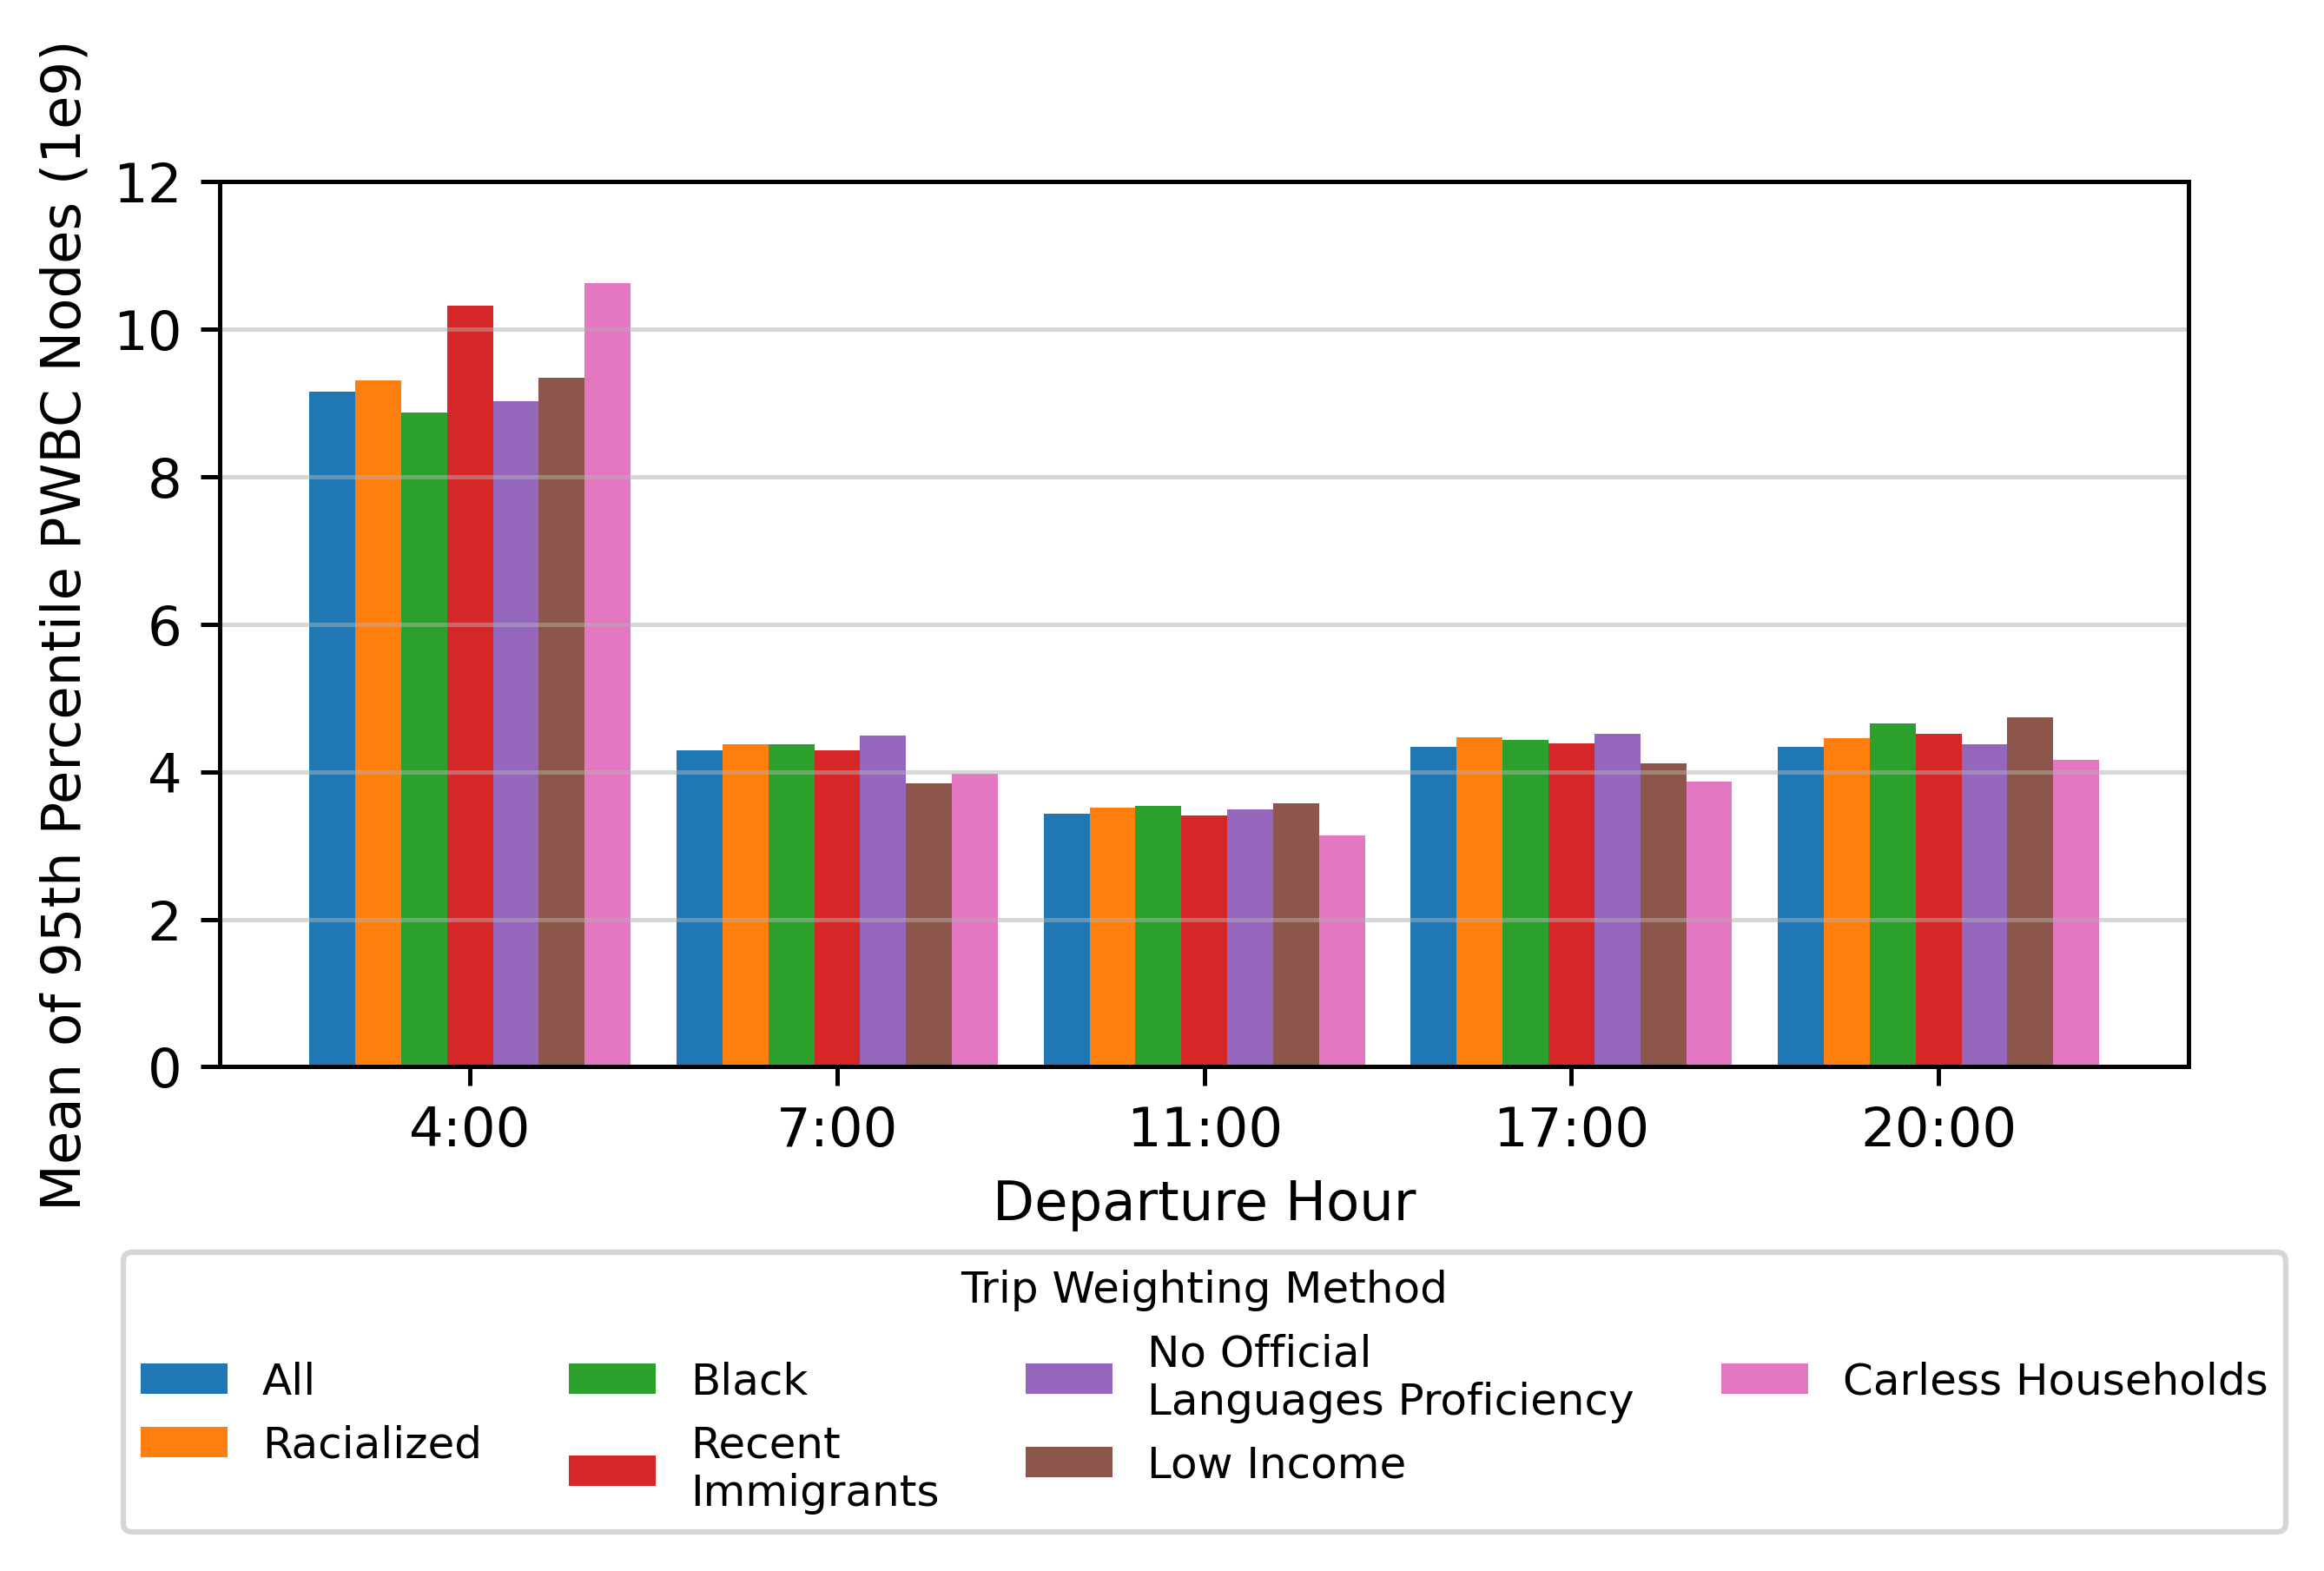

In [21]:
fig, ax = plt.subplots()

fig.set_size_inches(6.5,3)

x = np.arange(5) 

ax.grid(axis = 'y', alpha = 0.5)


plt.bar(x-3/8,bc_95_mean[bc_95_mean['group']=='raw']['weighted'], width = 1/8, label = 'All', color = cmap(0))
plt.bar(x-2/8,bc_95_mean[bc_95_mean['group']=='rac']['weighted'], width = 1/8, label = 'Racialized', color = cmap(1))
plt.bar(x-1/8,bc_95_mean[bc_95_mean['group']=='bl']['weighted'], width = 1/8, label = 'Black', color = cmap(2))
plt.bar(x,bc_95_mean[bc_95_mean['group']=='imm']['weighted'], width = 1/8, label = 'Recent\nImmigrants', color = cmap(3))
plt.bar(x+1/8,bc_95_mean[bc_95_mean['group']=='lep']['weighted'], width = 1/8, label = 'No Official\nLanguages Proficiency', color = cmap(4))
plt.bar(x+2/8,bc_95_mean[bc_95_mean['group']=='lico']['weighted'], width = 1/8, label = 'Low Income', color = cmap(5))
plt.bar(x+3/8,bc_95_mean[bc_95_mean['group']=='c0']['weighted'], width = 1/8, label = 'Carless Households', color = cmap(6))

ax.set_ylim([0,12])

ax.set_xticks(range(5))
ax.set_xticklabels(['4:00', '7:00', '11:00', '17:00', '20:00'])

ax.set_xlabel('Departure Hour')
ax.set_ylabel('Mean of 95th Percentile PWBC Nodes (1e9)')

plt.legend(title = 'Trip Weighting Method', title_fontsize = 8, fontsize = 8, ncol = 4, 
           loc='lower center', bbox_to_anchor=(0.5, -0.55))

plt.savefig('bc_mean.png', dpi = 300, bbox_inches = "tight")

In [22]:
bc_95_mean.to_csv('bc_95_mean.csv', index = False)
global_bc.to_csv('global_bc.csv', index = False)

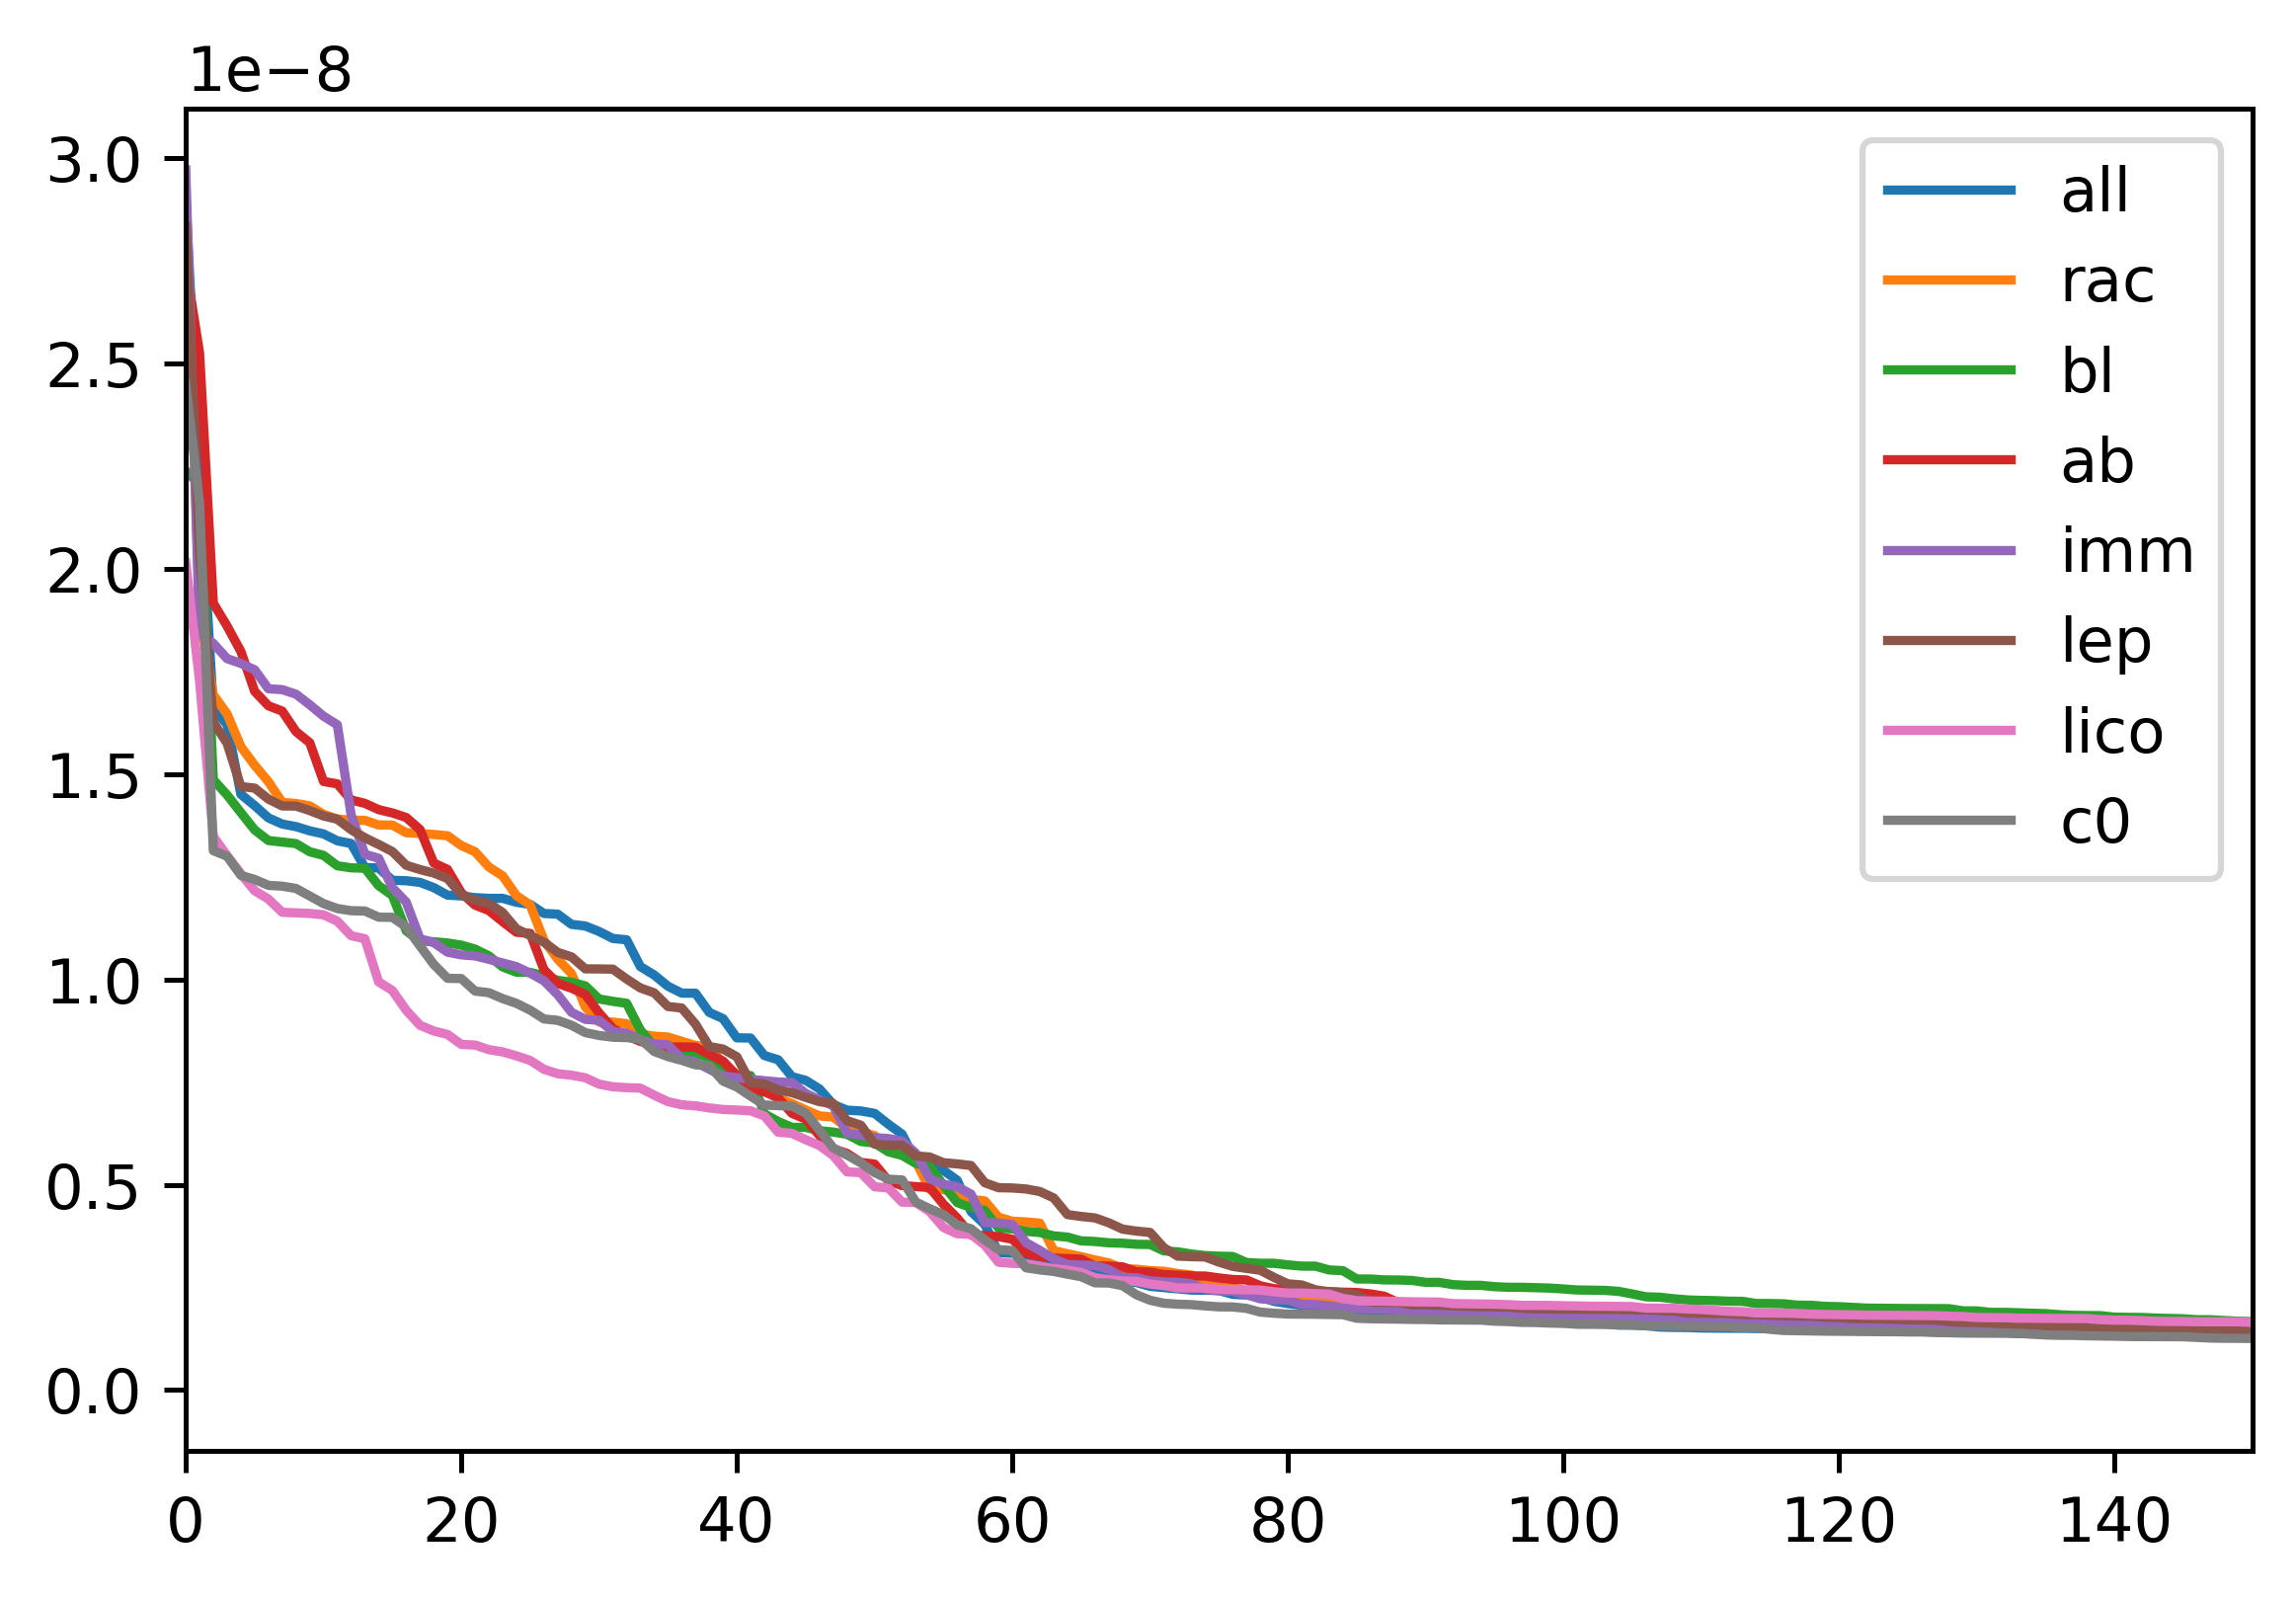

In [23]:
fig, ax = plt.subplots()

plt.plot(range(len(bc_weighted[bc_weighted['type']=='raw_am']['weighted'].sort_values(ascending = False))),
         bc_weighted[bc_weighted['type']=='raw_am']['weighted'].sort_values(ascending = False), label = 'all')

plt.plot(range(len(bc_weighted[bc_weighted['type']=='rac_am']['weighted'].sort_values(ascending = False))),
         bc_weighted[bc_weighted['type']=='rac_am']['weighted'].sort_values(ascending = False), label = 'rac')

plt.plot(range(len(bc_weighted[bc_weighted['type']=='bl_am']['weighted'].sort_values(ascending = False))),
         bc_weighted[bc_weighted['type']=='bl_am']['weighted'].sort_values(ascending = False), label = 'bl')

plt.plot(range(len(bc_weighted[bc_weighted['type']=='ab_am']['weighted'].sort_values(ascending = False))),
         bc_weighted[bc_weighted['type']=='ab_am']['weighted'].sort_values(ascending = False), label = 'ab')

plt.plot(range(len(bc_weighted[bc_weighted['type']=='imm_am']['weighted'].sort_values(ascending = False))),
         bc_weighted[bc_weighted['type']=='imm_am']['weighted'].sort_values(ascending = False), label = 'imm')

plt.plot(range(len(bc_weighted[bc_weighted['type']=='lep_am']['weighted'].sort_values(ascending = False))),
         bc_weighted[bc_weighted['type']=='lep_am']['weighted'].sort_values(ascending = False), label = 'lep')

plt.plot(range(len(bc_weighted[bc_weighted['type']=='lico_am']['weighted'].sort_values(ascending = False))),
         bc_weighted[bc_weighted['type']=='lico_am']['weighted'].sort_values(ascending = False), label = 'lico')

plt.plot(range(len(bc_weighted[bc_weighted['type']=='c0_am']['weighted'].sort_values(ascending = False))),
         bc_weighted[bc_weighted['type']=='c0_am']['weighted'].sort_values(ascending = False), label = 'c0')

ax.set_xlim([0,150])

ax.legend()